# Geographic Cost & Response Dataset Join

This notebook demonstrates how to use the geographic spine table to join marketing datasets at different geographic levels:

- GA4 Sessions (city level response metric)
- Meta Geo Spend (DMA level)
- TikTok Geo Spend (state level)
- Google Ads Geo Spend (city level)

The spine table acts as a geographic bridge, enabling accurate joins across these different geographic granularities.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings

# Add the project root to path to import our modules
sys.path.append('..')

# Import our custom data pipeline modules
from src.data_pipeline.data_standardizer import DateStandardizer, GeoStandardizer, CostStandardizer
from src.data_pipeline.data_joiner import DatasetCleaner
from src.data_pipeline.geo_joiner import GeoJoiner, GeoHierarchyJoiner

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')

# Set paths
RAW_DATA_PATH = '../raw_data/'
REFERENCE_DATA_PATH = '../data/reference/'
OUTPUT_PATH = '../data/processed/'

# Ensure output directory exists
os.makedirs(OUTPUT_PATH, exist_ok=True)

## 1. Load Raw Datasets

First, let's load all our datasets. Each dataset has a different geographic granularity.

In [2]:
# Load GA4 Sessions data (city level)
ga4_sessions = pd.read_csv(os.path.join(RAW_DATA_PATH, 'ga4_sessions.csv'))
#                            , nrows=10000)
print(f"GA4 Sessions shape: {ga4_sessions.shape}")
ga4_sessions.head()

GA4 Sessions shape: (100000, 7)


,Date,Region,Region ID,City,City ID,Sessions,Engaged sessions
0,20250319,(not set),(not set),(not set),(not set),19,1
1,20250319,Alabama,US-AL,Headland,1013037,1,0
2,20250319,Alabama,US-AL,Huntsville,1013042,1,0
3,20250319,Alabama,US-AL,Uniontown,9207090,1,1
4,20250319,Alaska,US-AK,Sitka,1012913,1,0


In [3]:
# Load Meta Geo Spend data (DMA level)
meta_geo_spend = pd.read_csv(os.path.join(RAW_DATA_PATH, 'meta_geo_spend.csv'))
#                              , nrows=10000)
print(f"Meta Geo Spend shape: {meta_geo_spend.shape}")
meta_geo_spend.head()

Meta Geo Spend shape: (93304, 6)


,DMA region,Day,Impressions,Amount spent (USD),Reporting starts,Reporting ends
0,Cheyenne-Scottsbluff,2025-03-20,9,0.549998,2025-03-20,2025-03-20
1,"Columbus, OH",2025-03-20,1264,44.799799,2025-03-20,2025-03-20
2,Salisbury,2025-03-20,207,8.639961,2025-03-20,2025-03-20
3,Austin,2025-03-20,2283,83.249627,2025-03-20,2025-03-20
4,Wichita-Hutchinson Plus,2025-03-20,358,10.569953,2025-03-20,2025-03-20


In [4]:
# Load TikTok Geo Spend data (state level)
tiktok_geo_spend = pd.read_csv(os.path.join(RAW_DATA_PATH, 'tiktok_geo_spend.csv')) #, nrows=10000)
print(f"TikTok Geo Spend shape: {tiktok_geo_spend.shape}")
tiktok_geo_spend.head()

TikTok Geo Spend shape: (10961, 5)


,By Day,Subregion,Cost,Impressions,Currency
0,3/20/25,Virginia,53.06,2204,USD
1,3/20/25,Montana,6.75,231,USD
2,3/20/25,Michigan,42.87,1696,USD
3,3/20/25,Illinois,77.01,2976,USD
4,3/20/25,Unknown,386.32,13627,USD


In [5]:
# Load Google Ads Geo Spend data (city level)
gads_geo_spend = pd.read_csv(os.path.join(RAW_DATA_PATH, 'gads_geo_spend.csv')) #, nrows=10000)
print(f"Google Ads Geo Spend shape: {gads_geo_spend.shape}")
gads_geo_spend.head()

Google Ads Geo Spend shape: (370818, 8)


,Day,Metro area (User location),City (User location),Region (User location),Country/Territory (User location),Currency code,Cost,Impr.
0,2024-01-01,Albany-Schenectady-Troy NY,Albany,New York,United States,USD,2.72,35
1,2024-01-01,Albany-Schenectady-Troy NY,Catskill,New York,United States,USD,3.33,39
2,2024-01-01,Albany-Schenectady-Troy NY,Delmar,New York,United States,USD,32.31,10
3,2024-01-01,Albany-Schenectady-Troy NY,Manchester,Vermont,United States,USD,1.41,13
4,2024-01-01,Amarillo TX,Dumas,Texas,United States,USD,1.73,4


## 2. Clean and Standardize Datasets

Let's clean and standardize our datasets using our existing data pipeline.

In [6]:
# Initialize standardizers
date_standardizer = DateStandardizer()
geo_standardizer = GeoStandardizer()
cost_standardizer = CostStandardizer()

# Initialize dataset cleaner
dataset_cleaner = DatasetCleaner(
    standardizers={
        'date': date_standardizer,
        'geo': geo_standardizer,
        'cost': cost_standardizer
    }
)

In [7]:
# Clean GA4 sessions data at city level
ga4_clean = dataset_cleaner.clean_ga4_sessions(ga4_sessions, geo_level='city')
print(f"Cleaned GA4 Sessions shape: {ga4_clean.shape}")
ga4_clean.head()

Cleaned GA4 Sessions shape: (100000, 5)


,Date,geo,location_id,Region,response
0,2024-04-01,ANAHEIM,1013542,CALIFORNIA,1
1,2024-04-01,ATLANTA,1015254,GEORGIA,24
2,2024-04-01,ATWATER,1013561,CALIFORNIA,1
3,2024-04-01,AURORA,1014437,COLORADO,1
4,2024-04-01,AVALON,1013564,CALIFORNIA,1


In [8]:
# Clean Meta spend data at DMA level
meta_clean = dataset_cleaner.clean_meta_spend(meta_geo_spend)
print(f"Cleaned Meta Spend shape: {meta_clean.shape}")
meta_clean.head()

Cleaned Meta Spend shape: (85756, 5)


,Date,geo,dma_name,dma_state,meta_cost
0,2024-01-01,ABILENE-SWEETWATER,ABILENE-SWEETWATER,ER,0.939899
1,2024-01-01,"ALBANY, GA","ALBANY, GA",GA,0.999893
2,2024-01-01,ALBANY-SCHENECTADY-TROY,ALBANY-SCHENECTADY-TROY,OY,16.838196
3,2024-01-01,ALBUQUERQUE-SANTA FE,ALBUQUERQUE-SANTA FE,FE,17.368139
4,2024-01-01,"ALEXANDRIA, LA","ALEXANDRIA, LA",LA,0.809913


In [9]:
# Clean TikTok spend data at state level
tiktok_clean = dataset_cleaner.clean_tiktok_spend(tiktok_geo_spend)
print(f"Cleaned TikTok Spend shape: {tiktok_clean.shape}")
tiktok_clean.head()

Cleaned TikTok Spend shape: (10961, 5)


,Date,geo,state,state_abbrev,tiktok_cost
0,2024-03-25,ALABAMA,ALABAMA,AL,1.48
1,2024-03-25,ALASKA,ALASKA,AK,0.33
2,2024-03-25,ARIZONA,ARIZONA,AZ,4.06
3,2024-03-25,ARKANSAS,ARKANSAS,AR,1.17
4,2024-03-25,CALIFORNIA,CALIFORNIA,CA,38.12


In [10]:
# Clean Google Ads spend data at city level
gads_clean = dataset_cleaner.clean_gads_spend(gads_geo_spend, geo_level='city')
print(f"Cleaned Google Ads Spend shape: {gads_clean.shape}")
gads_clean.head()

Cleaned Google Ads Spend shape: (356871, 6)


,Date,geo,Region,dma_name,dma_state,gads_cost
0,2024-01-01,AKRON,OHIO,CLEVELAND-AKRON (CANTON) OH,OH,1.03
1,2024-01-01,ALAMEDA,SAN FRANCISCO BAY AREA,SAN FRANCISCO-OAKLAND-SAN JOSE CA,CA,1.12
2,2024-01-01,ALAMO,SAN FRANCISCO BAY AREA,SAN FRANCISCO-OAKLAND-SAN JOSE CA,CA,7.26
3,2024-01-01,ALBANY,NEW YORK,ALBANY-SCHENECTADY-TROY NY,NY,2.72
4,2024-01-01,ALEXANDER CITY,ALABAMA,MONTGOMERY-SELMA AL,AL,7.66


## 3. Explore Geographic Spine Table

Let's take a look at our newly created geographic spine table and reference mappings.

In [11]:
# Load the geographic spine table
spine_table = pd.read_csv(os.path.join(REFERENCE_DATA_PATH, 'geo_spine.csv'))
print(f"Spine table shape: {spine_table.shape}")
spine_table.head()

Spine table shape: (40775, 10)


,zip_code,dma_code,dma_name,city,state,state_name,geo_key_zip,geo_key_city,geo_key_dma,geo_key_state
0,11005,501,NEW YORK,FLORAL PARK,NY,New York,11005,"FLORAL PARK, NY",NEW YORK,NY
1,11010,501,NEW YORK,FRANKLIN SQUARE,NY,New York,11010,"FRANKLIN SQUARE, NY",NEW YORK,NY
2,11020,501,NEW YORK,GREAT NECK,NY,New York,11020,"GREAT NECK, NY",NEW YORK,NY
3,11021,501,NEW YORK,GREAT NECK,NY,New York,11021,"GREAT NECK, NY",NEW YORK,NY
4,11023,501,NEW YORK,GREAT NECK,NY,New York,11023,"GREAT NECK, NY",NEW YORK,NY


In [12]:
# Look at the city-DMA mapping
city_dma_mapping = pd.read_csv(os.path.join(REFERENCE_DATA_PATH, 'city_dma_mapping.csv'))
print(f"City-DMA mapping shape: {city_dma_mapping.shape}")
city_dma_mapping.head()

City-DMA mapping shape: (24101, 4)


,city,state,dma_name,dma_code
0,HOUSTON,TX,HOUSTON,618
1,LOS ANGELES,CA,LOS ANGELES,803
2,DALLAS,TX,DALLAS-FT. WORTH,623
3,SAN ANTONIO,TX,SAN ANTONIO,641
4,NEW YORK,NY,NEW YORK,501


In [13]:
# Look at the DMA-state mapping
dma_state_mapping = pd.read_csv(os.path.join(REFERENCE_DATA_PATH, 'dma_state_mapping.csv'))
print(f"DMA-state mapping shape: {dma_state_mapping.shape}")
dma_state_mapping.head()

DMA-state mapping shape: (210, 3)


,dma_name,dma_code,state
0,ABILENE-SWEETWATER,662,['TX']
1,"ALBANY, GA",525,['GA']
2,ALBANY-SCHENECTADY-TROY,532,"['MA', 'NY', 'VT']"
3,ALBUQUERQUE-SANTA FE,790,"['AZ', 'NM']"
4,"ALEXANDRIA, LA",644,['LA']


## 4. Enrich Datasets with Geographic Reference Data

Now let's use the GeoJoiner to enrich our datasets with the geographic reference data.

In [14]:
# Initialize GeoJoiner with reference data path
geo_joiner = GeoJoiner(reference_data_path=REFERENCE_DATA_PATH)

In [15]:
ga4_clean.head()

,Date,geo,location_id,Region,response
0,2024-04-01,ANAHEIM,1013542,CALIFORNIA,1
1,2024-04-01,ATLANTA,1015254,GEORGIA,24
2,2024-04-01,ATWATER,1013561,CALIFORNIA,1
3,2024-04-01,AURORA,1014437,COLORADO,1
4,2024-04-01,AVALON,1013564,CALIFORNIA,1


In [16]:
# Enrich GA4 city-level data with DMA information
ga4_enriched = geo_joiner.enrich_city_data(
    ga4_clean, 
    city_col='geo', 
    state_col='Region'
)
print(f"Enriched GA4 Sessions shape: {ga4_enriched.shape}")
print(f"Original GA4 Sessions shape: {ga4_clean.shape}")

ga4_enriched.head()



Sample city values in input data: ['ANAHEIM', 'ATLANTA', 'ATWATER', 'AURORA', 'AVALON']
Sample city values in mapping: ['HOUSTON', 'LOS ANGELES', 'DALLAS', 'SAN ANTONIO', 'NEW YORK']
Sample state values in input data: ['CALIFORNIA', 'GEORGIA', 'CALIFORNIA', 'COLORADO', 'CALIFORNIA']
Sample state values in mapping: ['TX', 'CA', 'TX', 'TX', 'NY']
Converting full state names to abbreviations
Joining on columns: geo and state_abbrev
Join results: 83792 matches, 16208 NaN values out of 100000 total
Enriched GA4 Sessions shape: (100000, 10)
Original GA4 Sessions shape: (100000, 5)


,Date,geo,location_id,Region,response,state_abbrev,city,state,dma_name,dma_code
0,2024-04-01,ANAHEIM,1013542,CALIFORNIA,1,CA,ANAHEIM,CA,LOS ANGELES,803.0
1,2024-04-01,ATLANTA,1015254,GEORGIA,24,GA,ATLANTA,GA,ATLANTA,524.0
2,2024-04-01,ATWATER,1013561,CALIFORNIA,1,CA,ATWATER,CA,FRESNO-VISALIA,866.0
3,2024-04-01,AURORA,1014437,COLORADO,1,CO,AURORA,CO,DENVER,751.0
4,2024-04-01,AVALON,1013564,CALIFORNIA,1,CA,AVALON,CA,LOS ANGELES,803.0


In [17]:
ga4_enriched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          100000 non-null  object 
 1   geo           100000 non-null  object 
 2   location_id   100000 non-null  object 
 3   Region        100000 non-null  object 
 4   response      100000 non-null  int64  
 5   state_abbrev  100000 non-null  object 
 6   city          83792 non-null   object 
 7   state         83792 non-null   object 
 8   dma_name      83792 non-null   object 
 9   dma_code      83792 non-null   float64
dtypes: float64(1), int64(1), object(8)
memory usage: 8.4+ MB


In [20]:
ga4_enriched.loc[ga4_enriched['city'].isna()].head()

,Date,geo,location_id,Region,response,state_abbrev,city,state,dma_name,dma_code
9,2024-04-01,BOCA DEL MAR,9051612,FLORIDA,1,FL,NaN,NaN,NaN,NaN
30,2024-04-01,DREXEL HEIGHTS,9051843,ARIZONA,1,AZ,NaN,NaN,NaN,NaN
32,2024-04-01,EASTVALE,9051887,CALIFORNIA,3,CA,NaN,NaN,NaN,NaN
39,2024-04-01,FOUR CORNERS,9051981,FLORIDA,1,FL,NaN,NaN,NaN,NaN
45,2024-04-01,HAMPTONS AT BOCA RATON,9052094,FLORIDA,13,FL,NaN,NaN,NaN,NaN


In [21]:
print(gads_clean.info())

gads_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356871 entries, 0 to 356870
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       356871 non-null  object 
 1   geo        356871 non-null  object 
 2   Region     356871 non-null  object 
 3   dma_name   356871 non-null  object 
 4   dma_state  356871 non-null  object 
 5   gads_cost  356871 non-null  float64
dtypes: float64(1), object(5)
memory usage: 16.3+ MB
None


,Date,geo,Region,dma_name,dma_state,gads_cost
0,2024-01-01,AKRON,OHIO,CLEVELAND-AKRON (CANTON) OH,OH,1.03
1,2024-01-01,ALAMEDA,SAN FRANCISCO BAY AREA,SAN FRANCISCO-OAKLAND-SAN JOSE CA,CA,1.12
2,2024-01-01,ALAMO,SAN FRANCISCO BAY AREA,SAN FRANCISCO-OAKLAND-SAN JOSE CA,CA,7.26
3,2024-01-01,ALBANY,NEW YORK,ALBANY-SCHENECTADY-TROY NY,NY,2.72
4,2024-01-01,ALEXANDER CITY,ALABAMA,MONTGOMERY-SELMA AL,AL,7.66


In [22]:
# Enrich Google Ads city-level data with DMA information
gads_enriched = geo_joiner.enrich_city_data(
    gads_clean, 
    city_col='geo', 
    state_col='dma_state'  # Use 'Region' as shown in your data sample
)
print(f"Enriched Google Ads Spend shape: {gads_enriched.shape}")
print(f"Original Google Ads Spend Shape: {gads_clean.shape}")
gads_enriched.head()

Sample city values in input data: ['AKRON', 'ALAMEDA', 'ALAMO', 'ALBANY', 'ALEXANDER CITY']
Sample city values in mapping: ['HOUSTON', 'LOS ANGELES', 'DALLAS', 'SAN ANTONIO', 'NEW YORK']
Sample state values in input data: ['OH', 'CA', 'CA', 'NY', 'AL']
Sample state values in mapping: ['TX', 'CA', 'TX', 'TX', 'NY']
Joining on columns: geo and dma_state
Join results: 0 matches, 356871 NaN values out of 356871 total
Enriched Google Ads Spend shape: (356871, 10)
Original Google Ads Spend Shape: (356871, 6)


,Date,geo,Region,dma_name_x,dma_state,gads_cost,city,state,dma_name_y,dma_code
0,2024-01-01,AKRON,OHIO,CLEVELAND-AKRON (CANTON) OH,OH,1.03,AKRON,OH,CLEVELAND-AKRON (CANTON),510.0
1,2024-01-01,ALAMEDA,SAN FRANCISCO BAY AREA,SAN FRANCISCO-OAKLAND-SAN JOSE CA,CA,1.12,ALAMEDA,CA,SAN FRANCISCO-OAK-SAN JOSE,807.0
2,2024-01-01,ALAMO,SAN FRANCISCO BAY AREA,SAN FRANCISCO-OAKLAND-SAN JOSE CA,CA,7.26,ALAMO,CA,SAN FRANCISCO-OAK-SAN JOSE,807.0
3,2024-01-01,ALBANY,NEW YORK,ALBANY-SCHENECTADY-TROY NY,NY,2.72,ALBANY,NY,ALBANY-SCHENECTADY-TROY,532.0
4,2024-01-01,ALEXANDER CITY,ALABAMA,MONTGOMERY-SELMA AL,AL,7.66,ALEXANDER CITY,AL,MONTGOMERY-SELMA,698.0


In [23]:
# For Meta data, we just need to pass the DataFrame and column name
meta_enriched = geo_joiner.enrich_dma_data(
    meta_clean,
    'geo'  # This is the column name in meta_clean containing DMA names
)

# For TikTok data, we can use it as is since it's state-level
tiktok_enriched = tiktok_clean


# For Meta data, we need to add the dma_name column (which should match the geo column)
meta_enriched = meta_enriched.copy()
meta_enriched['dma_name'] = meta_enriched['geo'].str.strip().str.upper()

# For TikTok data, we need to add a state column
tiktok_enriched = tiktok_enriched.copy()
tiktok_enriched['state'] = tiktok_enriched['geo'].str.strip().str.upper()


print(f"Enriched Meta Ads Spend shape: {meta_enriched.shape}")
print(f"Original Google Ads Spend Shape: {meta_clean.shape}")
meta_clean.head()

Enriched Meta Ads Spend shape: (85756, 9)
Original Google Ads Spend Shape: (85756, 5)


,Date,geo,dma_name,dma_state,meta_cost
0,2024-01-01,ABILENE-SWEETWATER,ABILENE-SWEETWATER,ER,0.939899
1,2024-01-01,"ALBANY, GA","ALBANY, GA",GA,0.999893
2,2024-01-01,ALBANY-SCHENECTADY-TROY,ALBANY-SCHENECTADY-TROY,OY,16.838196
3,2024-01-01,ALBUQUERQUE-SANTA FE,ALBUQUERQUE-SANTA FE,FE,17.368139
4,2024-01-01,"ALEXANDRIA, LA","ALEXANDRIA, LA",LA,0.809913


In [24]:
print(f"Enriched TikTok Ads Spend shape: {tiktok_enriched.shape}")
print(f"Original TikTok Ads Spend Shape: {tiktok_clean.shape}")
meta_clean.head()

Enriched TikTok Ads Spend shape: (10961, 5)
Original TikTok Ads Spend Shape: (10961, 5)


,Date,geo,dma_name,dma_state,meta_cost
0,2024-01-01,ABILENE-SWEETWATER,ABILENE-SWEETWATER,ER,0.939899
1,2024-01-01,"ALBANY, GA","ALBANY, GA",GA,0.999893
2,2024-01-01,ALBANY-SCHENECTADY-TROY,ALBANY-SCHENECTADY-TROY,OY,16.838196
3,2024-01-01,ALBUQUERQUE-SANTA FE,ALBUQUERQUE-SANTA FE,FE,17.368139
4,2024-01-01,"ALEXANDRIA, LA","ALEXANDRIA, LA",LA,0.809913


In [25]:
tiktok_enriched.head()

,Date,geo,state,state_abbrev,tiktok_cost
0,2024-03-25,ALABAMA,ALABAMA,AL,1.48
1,2024-03-25,ALASKA,ALASKA,AK,0.33
2,2024-03-25,ARIZONA,ARIZONA,AZ,4.06
3,2024-03-25,ARKANSAS,ARKANSAS,AR,1.17
4,2024-03-25,CALIFORNIA,CALIFORNIA,CA,38.12


## 5. Join Datasets Using Geographic Hierarchy

Now let's use the GeoHierarchyJoiner to join datasets with different geographic granularities.

In [26]:
# Initialize the GeoHierarchyJoiner
hierarchy_joiner = GeoHierarchyJoiner(reference_data_path=REFERENCE_DATA_PATH)

In [27]:
# Check the columns in each dataset to verify enrichment
print("GA4 enriched columns:", ga4_enriched.columns.tolist())
print("Google enriched Ads columns:", gads_enriched.columns.tolist())
print("Meta enriched columns:", meta_enriched.columns.tolist())
print("TikTok enriched columns:", tiktok_enriched.columns.tolist())

GA4 enriched columns: ['Date', 'geo', 'location_id', 'Region', 'response', 'state_abbrev', 'city', 'state', 'dma_name', 'dma_code']
Google enriched Ads columns: ['Date', 'geo', 'Region', 'dma_name_x', 'dma_state', 'gads_cost', 'city', 'state', 'dma_name_y', 'dma_code']
Meta enriched columns: ['Date', 'geo', 'dma_name_x', 'dma_state', 'meta_cost', 'dma_name_y', 'dma_code', 'state', 'dma_name']
TikTok enriched columns: ['Date', 'geo', 'state', 'state_abbrev', 'tiktok_cost']


In [28]:
tiktok_enriched.head()

,Date,geo,state,state_abbrev,tiktok_cost
0,2024-03-25,ALABAMA,ALABAMA,AL,1.48
1,2024-03-25,ALASKA,ALASKA,AK,0.33
2,2024-03-25,ARIZONA,ARIZONA,AZ,4.06
3,2024-03-25,ARKANSAS,ARKANSAS,AR,1.17
4,2024-03-25,CALIFORNIA,CALIFORNIA,CA,38.12


In [29]:
# Start with GA4 enriched data as the base
result_df = ga4_enriched.copy()
print(f"Starting with GA4 data: {result_df.shape}")

# Do a left join with Google Ads data to preserve all GA4 records
result_df = pd.merge(
    result_df,
    gads_enriched[['Date', 'geo', 'city', 'state', 'gads_cost']],
    on=['Date', 'geo', 'city', 'state'],
    how='left',
    suffixes=('', '_gads')
)
print(f"After left join with Google Ads: {result_df.shape}")

# Join with Meta data at DMA level
result_df = pd.merge(
    result_df,
    meta_enriched[['Date', 'dma_name', 'meta_cost']],
    on=['Date', 'dma_name'],
    how='left',
    suffixes=('', '_meta')
)
print(f"After join with Meta: {result_df.shape}")

# First, make sure TikTok data has state_join column
if 'state_join' not in tiktok_enriched.columns:
    # Create state_join from state using the mapping
    state_mapping = {
        'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR', 'CALIFORNIA': 'CA',
        'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE', 'FLORIDA': 'FL', 'GEORGIA': 'GA',
        'HAWAII': 'HI', 'IDAHO': 'ID', 'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA',
        'KANSAS': 'KS', 'KENTUCKY': 'KY', 'LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD',
        'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 'MISSISSIPPI': 'MS', 'MISSOURI': 'MO',
        'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV', 'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ',
        'NEW MEXICO': 'NM', 'NEW YORK': 'NY', 'NORTH CAROLINA': 'NC', 'NORTH DAKOTA': 'ND', 'OHIO': 'OH',
        'OKLAHOMA': 'OK', 'OREGON': 'OR', 'PENNSYLVANIA': 'PA', 'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC',
        'SOUTH DAKOTA': 'SD', 'TENNESSEE': 'TN', 'TEXAS': 'TX', 'UTAH': 'UT', 'VERMONT': 'VT',
        'VIRGINIA': 'VA', 'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV', 'WISCONSIN': 'WI', 'WYOMING': 'WY'
    }
    tiktok_enriched['state_join'] = tiktok_enriched['state'].apply(
        lambda x: state_mapping.get(x, x) if x in state_mapping else x
    )
    print(f"Added state_join to TikTok data")

# Make sure result_df has state_join
if 'state_join' not in result_df.columns:
    # If GA4 data has state but not state_join, add it
    if 'state' in result_df.columns:
        result_df['state_join'] = result_df['state']
        print(f"Added state_join to result_df based on state column")

# Now join with TikTok data
result_df = pd.merge(
    result_df,
    tiktok_enriched[['Date', 'state_join', 'tiktok_cost']],
    on=['Date', 'state_join'],
    how='left',
    suffixes=('', '_tiktok')
)
print(f"After join with TikTok: {result_df.shape}")

# Fill NA values with 0 for cost columns
cost_cols = ['gads_cost', 'meta_cost', 'tiktok_cost']
available_cost_cols = [col for col in cost_cols if col in result_df.columns]
result_df[available_cost_cols] = result_df[available_cost_cols].fillna(0)

# Select and rename final columns
final_cols = {
    'Date': 'Date',
    'city': 'City',
    'state': 'State',
    'dma_name': 'DMA',
    'geo': 'ZIP',
    'response': 'sessions',  # Changed from 'Sessions' to 'response'
    'meta_cost': 'fb_dma_cost',
    'tiktok_cost': 'tiktok_state_cost',
    'gads_cost': 'google_cost'
}

# Keep only the columns that exist in the result
available_cols = [col for col in final_cols.keys() if col in result_df.columns]
final_df = result_df[available_cols].rename(columns={col: final_cols[col] for col in available_cols})

print(f"\nFinal dataset shape: {final_df.shape}")

final_df.head()

Starting with GA4 data: (100000, 10)
After left join with Google Ads: (100626, 11)
After join with Meta: (100626, 12)
Added state_join to TikTok data
Added state_join to result_df based on state column
After join with TikTok: (100626, 14)

Final dataset shape: (100626, 9)


,Date,City,State,DMA,ZIP,sessions,fb_dma_cost,tiktok_state_cost,google_cost
0,2024-04-01,ANAHEIM,CA,LOS ANGELES,ANAHEIM,1,319.558080,85.32,2.60
1,2024-04-01,ATLANTA,GA,ATLANTA,ATLANTA,24,129.417073,20.33,26.02
2,2024-04-01,ATWATER,CA,FRESNO-VISALIA,ATWATER,1,13.298672,85.32,0.00
3,2024-04-01,AURORA,CO,DENVER,AURORA,1,76.282380,12.08,0.00
4,2024-04-01,AVALON,CA,LOS ANGELES,AVALON,1,319.558080,85.32,0.00


# Session-Based Cost Allocation

Our data structure presents a challenge: we have response metrics (GA4 sessions) and Google Ads costs at the city level, but Meta costs at the DMA level and TikTok costs at the state level. For match market analysis, we need all metrics at the same granularity.

We're using session-based allocation to distribute the higher-level costs (DMA/state) to city level by calculating each city's proportion of sessions within its region. This approach is ideal because it:

1. Uses actual user engagement data we already have
2. Reflects that cities with more sessions likely received more advertising exposure
3. Creates consistent metrics for accurate ROI comparison across cities and channels

In [30]:
# Calculate city's proportion of DMA/state sessions
final_df['city_dma_session_ratio'] = final_df['sessions'] / final_df.groupby(['Date', 'DMA'])['sessions'].transform('sum')
final_df['city_state_session_ratio'] = final_df['sessions'] / final_df.groupby(['Date', 'State'])['sessions'].transform('sum')

# Replace NaN with 0 (for cities with no sessions)
final_df['city_dma_session_ratio'].fillna(0, inplace=True)
final_df['city_state_session_ratio'].fillna(0, inplace=True)

# Create normalized costs
final_df['facebook_cost_city_normalized'] = final_df['fb_dma_cost'] * final_df['city_dma_session_ratio']
final_df['tiktok_cost_city_normalized'] = final_df['tiktok_state_cost'] * final_df['city_state_session_ratio']

In [31]:
final_df.head()

,Date,City,State,DMA,ZIP,sessions,fb_dma_cost,tiktok_state_cost,google_cost,city_dma_session_ratio,city_state_session_ratio,facebook_cost_city_normalized,tiktok_cost_city_normalized
0,2024-04-01,ANAHEIM,CA,LOS ANGELES,ANAHEIM,1,319.558080,85.32,2.60,0.020000,0.006329,6.391162,0.540000
1,2024-04-01,ATLANTA,GA,ATLANTA,ATLANTA,24,129.417073,20.33,26.02,0.923077,0.727273,119.461913,14.785455
2,2024-04-01,ATWATER,CA,FRESNO-VISALIA,ATWATER,1,13.298672,85.32,0.00,0.200000,0.006329,2.659734,0.540000
3,2024-04-01,AURORA,CO,DENVER,AURORA,1,76.282380,12.08,0.00,0.038462,0.037037,2.933938,0.447407
4,2024-04-01,AVALON,CA,LOS ANGELES,AVALON,1,319.558080,85.32,0.00,0.020000,0.006329,6.391162,0.540000


## 6. Create Final Cost-Response Dataset

Now let's create our final cost-response dataset ready for analysis.

In [34]:

# Add total cost column
cost_cols = [col for col in final_df.columns if 'cost' in col.lower()]

normalized_cost_cols = [
 'google_cost',
 'facebook_cost_city_normalized',
 'tiktok_cost_city_normalized'
]

final_df['total_cost'] = final_df[normalized_cost_cols].sum(axis=1, skipna=True)

# Ensure date is in datetime format
if 'Date' in final_df.columns:
    final_df['Date'] = pd.to_datetime(final_df['Date'])

# Sort by date and geography
sort_cols = ['Date']
if 'City' in final_df.columns:
    sort_cols.append('City')
final_df = final_df.sort_values(sort_cols).reset_index(drop=True)

final_df.head()

,Date,City,State,DMA,ZIP,sessions,fb_dma_cost,tiktok_state_cost,google_cost,city_dma_session_ratio,city_state_session_ratio,facebook_cost_city_normalized,tiktok_cost_city_normalized,total_cost
0,2024-04-01,ANAHEIM,CA,LOS ANGELES,ANAHEIM,1,319.558080,85.32,2.60,0.020000,0.006329,6.391162,0.540000,9.531162
1,2024-04-01,ATLANTA,GA,ATLANTA,ATLANTA,24,129.417073,20.33,26.02,0.923077,0.727273,119.461913,14.785455,160.267368
2,2024-04-01,ATWATER,CA,FRESNO-VISALIA,ATWATER,1,13.298672,85.32,0.00,0.200000,0.006329,2.659734,0.540000,3.199734
3,2024-04-01,AURORA,CO,DENVER,AURORA,1,76.282380,12.08,0.00,0.038462,0.037037,2.933938,0.447407,3.381345
4,2024-04-01,AVALON,CA,LOS ANGELES,AVALON,1,319.558080,85.32,0.00,0.020000,0.006329,6.391162,0.540000,6.931162


## 7. Data Quality Checks

Let's run some data quality checks on our final dataset.

In [35]:
# Check for missing values
final_df.isnull().sum()

Date                                 0
City                             16239
State                            16239
DMA                              16239
ZIP                                  0
sessions                             0
fb_dma_cost                          0
tiktok_state_cost                    0
google_cost                          0
city_dma_session_ratio               0
city_state_session_ratio             0
facebook_cost_city_normalized        0
tiktok_cost_city_normalized          0
total_cost                           0
dtype: int64

In [36]:
# Basic summary statistics
final_df.describe()

,sessions,fb_dma_cost,tiktok_state_cost,google_cost,city_dma_session_ratio,city_state_session_ratio,facebook_cost_city_normalized,tiktok_cost_city_normalized,total_cost
count,100626.000000,100626.000000,100626.000000,100626.000000,100626.000000,100626.000000,100626.000000,100626.000000,100626.000000
mean,2.749598,57.294254,18.918599,9.532274,0.346710,0.152267,9.690329,1.475176,20.697780
std,7.602846,104.071965,45.949806,63.246256,0.372145,0.226061,26.853368,5.098998,88.075972
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.026316,0.010989,0.000000,0.000000,1.269395
50%,1.000000,11.769193,0.000000,0.000000,0.176471,0.058824,3.426501,0.000000,5.185766
75%,1.000000,64.368592,14.680000,1.860000,0.562500,0.192308,8.651619,1.058571,13.105840
max,742.000000,1011.821893,381.060000,3175.830000,1.000000,1.000000,786.825217,165.120000,3460.116081


In [37]:
# Check for records with no response but have costs
no_response_with_cost = final_df[(final_df['sessions'] == 0) & (final_df['total_cost'] > 0)]
print(f"Records with cost but no response: {len(no_response_with_cost)}")
no_response_with_cost.head()

Records with cost but no response: 0


,Date,City,State,DMA,ZIP,sessions,fb_dma_cost,tiktok_state_cost,google_cost,city_dma_session_ratio,city_state_session_ratio,facebook_cost_city_normalized,tiktok_cost_city_normalized,total_cost


In [38]:
# Check for records with response but no costs
response_no_cost = final_df[(final_df['sessions'] > 0) & (final_df['total_cost'] == 0)]
print(f"Records with response but no cost: {len(response_no_cost)}")
response_no_cost.head()

Records with response but no cost: 18787


,Date,City,State,DMA,ZIP,sessions,fb_dma_cost,tiktok_state_cost,google_cost,city_dma_session_ratio,city_state_session_ratio,facebook_cost_city_normalized,tiktok_cost_city_normalized,total_cost
106,2024-04-01,NaN,NaN,NaN,BOCA DEL MAR,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,2024-04-01,NaN,NaN,NaN,DREXEL HEIGHTS,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,2024-04-01,NaN,NaN,NaN,EASTVALE,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,2024-04-01,NaN,NaN,NaN,FOUR CORNERS,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,2024-04-01,NaN,NaN,NaN,JASMINE ESTATES,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
cost_cols

['fb_dma_cost',
 'tiktok_state_cost',
 'google_cost',
 'facebook_cost_city_normalized',
 'tiktok_cost_city_normalized',
 'total_cost']

In [40]:
# Check distribution of costs by platform
# get rid of fb and tiktok duped cost
normalized_cost_cols = [
 'google_cost',
 'facebook_cost_city_normalized',
 'tiktok_cost_city_normalized'
]

platform_costs = final_df[normalized_cost_cols].sum()
platform_costs

google_cost                      959194.650000
facebook_cost_city_normalized    975099.018808
tiktok_cost_city_normalized      148441.110000
dtype: float64

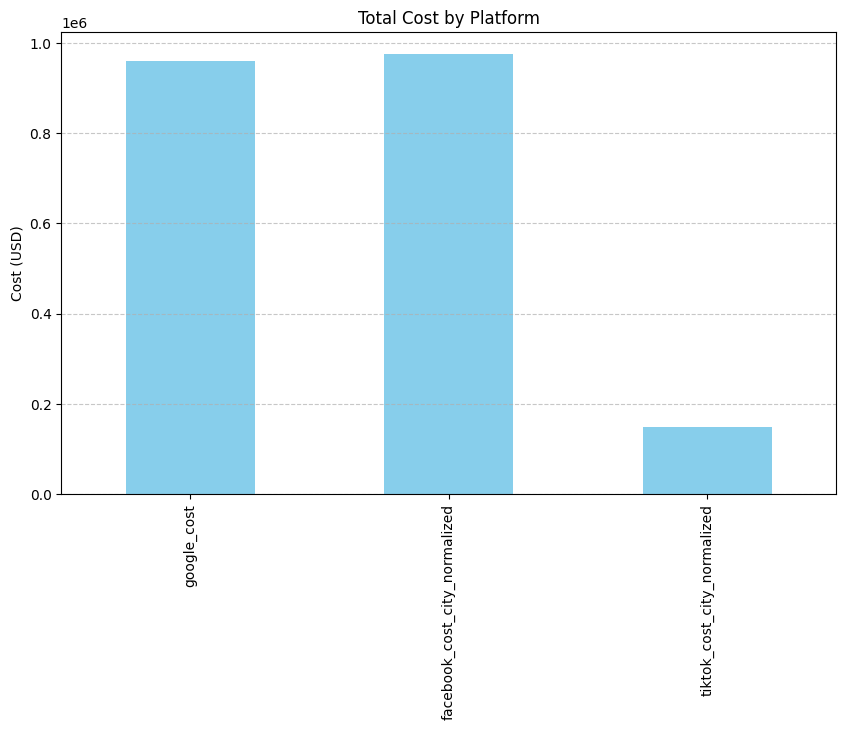

In [41]:
# Visualize platform cost distribution
plt.figure(figsize=(10, 6))
platform_costs.plot(kind='bar', color='skyblue')
plt.title('Total Cost by Platform')
plt.ylabel('Cost (USD)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 8. Save the Final Dataset

Save the final cost-response dataset for further analysis.

In [42]:
# Create a mapping of unique city-state combinations to sequential IDs
city_state_pairs = final_df[['City', 'State']].drop_duplicates().reset_index(drop=True)
city_state_pairs['geo_id'] = city_state_pairs.index + 1  # Start IDs from 1

# Merge this back to the main dataframe
final_df = pd.merge(
    final_df,
    city_state_pairs,
    on=['City', 'State'],
    how='left'
)

final_df.head()

,Date,City,State,DMA,ZIP,sessions,fb_dma_cost,tiktok_state_cost,google_cost,city_dma_session_ratio,city_state_session_ratio,facebook_cost_city_normalized,tiktok_cost_city_normalized,total_cost,geo_id
0,2024-04-01,ANAHEIM,CA,LOS ANGELES,ANAHEIM,1,319.558080,85.32,2.60,0.020000,0.006329,6.391162,0.540000,9.531162,1
1,2024-04-01,ATLANTA,GA,ATLANTA,ATLANTA,24,129.417073,20.33,26.02,0.923077,0.727273,119.461913,14.785455,160.267368,2
2,2024-04-01,ATWATER,CA,FRESNO-VISALIA,ATWATER,1,13.298672,85.32,0.00,0.200000,0.006329,2.659734,0.540000,3.199734,3
3,2024-04-01,AURORA,CO,DENVER,AURORA,1,76.282380,12.08,0.00,0.038462,0.037037,2.933938,0.447407,3.381345,4
4,2024-04-01,AVALON,CA,LOS ANGELES,AVALON,1,319.558080,85.32,0.00,0.020000,0.006329,6.391162,0.540000,6.931162,5


In [51]:
print(final_df.sessions.sum())
print(ga4_clean.columns)
print(ga4_clean.response.sum())

ga4_clean.head()

276681
Index(['Date', 'geo', 'location_id', 'Region', 'response'], dtype='object')
269222


,Date,geo,location_id,Region,response
0,2024-04-01,ANAHEIM,1013542,CALIFORNIA,1
1,2024-04-01,ATLANTA,1015254,GEORGIA,24
2,2024-04-01,ATWATER,1013561,CALIFORNIA,1
3,2024-04-01,AURORA,1014437,COLORADO,1
4,2024-04-01,AVALON,1013564,CALIFORNIA,1


In [53]:
# Create dataset for design file

needed_cols = ['Date', 'geo_id', 'total_cost', 'sessions']

client_dataset = final_df[needed_cols]

client_dataset = client_dataset.rename(columns={
    "Date": "date",
    "geo_id": "geo",
    "total_cost": "cost",
    "sessions": "response"
}, inplace=False)

client_dataset.head()


,date,geo,cost,response
0,2024-04-01,1,9.531162,1
1,2024-04-01,2,160.267368,24
2,2024-04-01,3,3.199734,1
3,2024-04-01,4,3.381345,1
4,2024-04-01,5,6.931162,1


In [54]:
# Save the final datasets
output_file = os.path.join(OUTPUT_PATH, 'cost_response_data_wide.csv')
final_df.to_csv(output_file, index=False)
print(f"Final dataset saved to {output_file}")

output_file = os.path.join(OUTPUT_PATH, 'cost_response_data_design_input.csv')
client_dataset.to_csv(output_file, index=False)
print(f"Final dataset saved to {output_file}")

Final dataset saved to ../data/processed/cost_response_data_wide.csv
Final dataset saved to ../data/processed/cost_response_data_design_input.csv


## 9. Cost-Response Analysis

Finally, let's do some basic cost-response analysis.

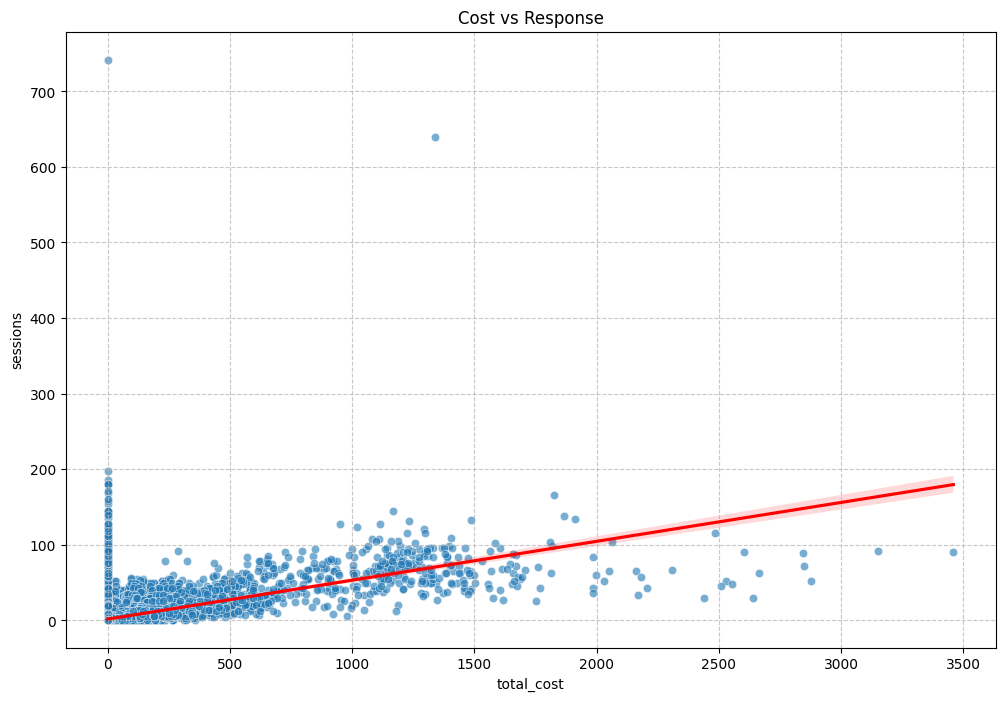

In [45]:
# Scatter plot of cost vs response
plt.figure(figsize=(12, 8))
sns.scatterplot(data=final_df, x='total_cost', y='sessions', alpha=0.6)
plt.title('Cost vs Response')
plt.xlabel('Cost (USD)')
plt.ylabel('Response (Sessions)')
plt.grid(True, linestyle='--', alpha=0.7)

# Add trend line
sns.regplot(data=final_df, x='total_cost', y='sessions', 
            scatter=False, line_kws={'color': 'red'})

plt.show()

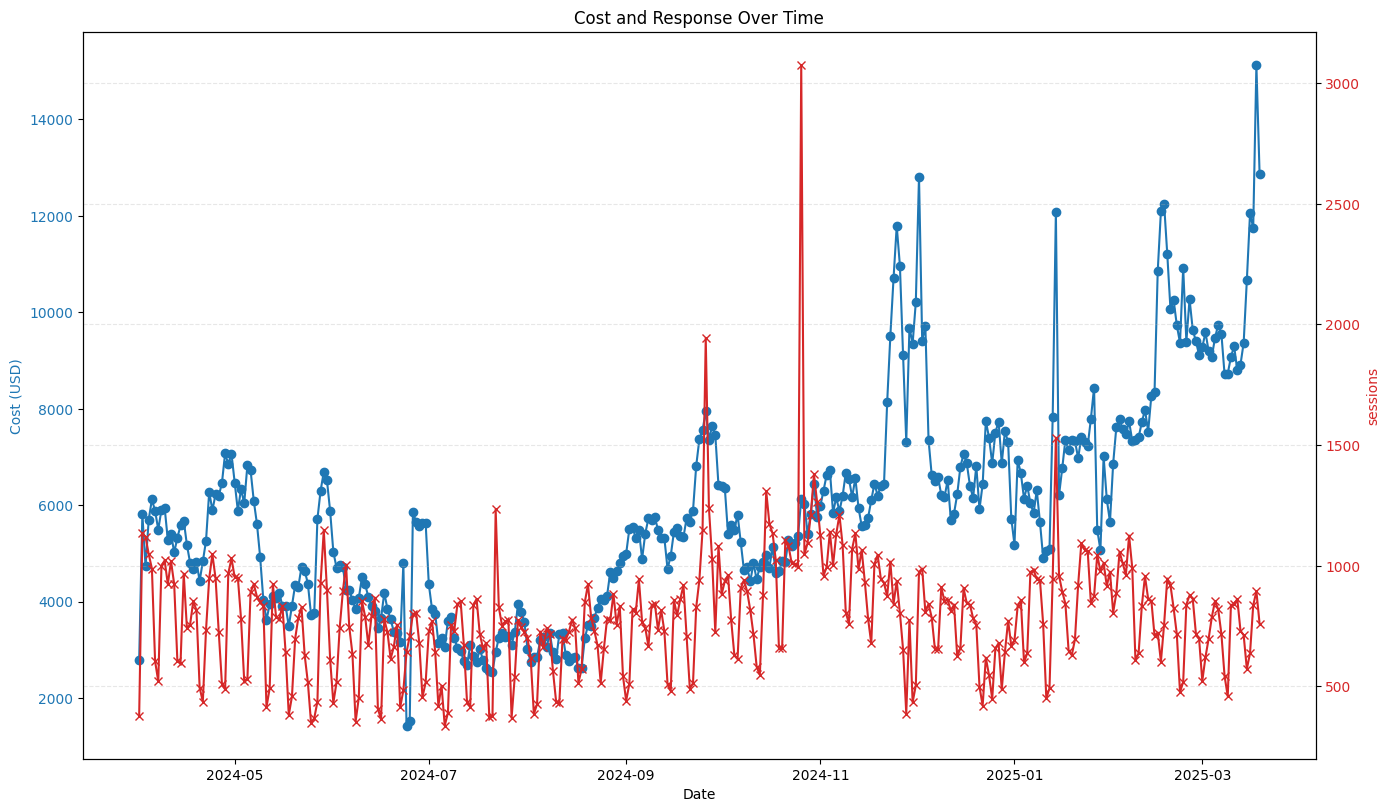

In [46]:
# Time series of cost and response over time
# Aggregate by date
time_series = final_df.groupby('Date').agg({
    'sessions': 'sum',
    'total_cost': 'sum'
}).reset_index()

# Plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Cost on left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Cost (USD)', color='tab:blue')
ax1.plot(time_series['Date'], time_series['total_cost'], color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Response on right y-axis
ax2 = ax1.twinx()
ax2.set_ylabel('sessions', color='tab:red')
ax2.plot(time_series['Date'], time_series['sessions'], color='tab:red', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Cost and Response Over Time')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## Conclusion

In this notebook, we've demonstrated how to use the geographic spine table to join datasets at different geographic levels. The key benefits of this approach are:

1. Accurately joining data at different geographic granularities (city, DMA, state)
2. Creating a consistent dataset for cost-response analysis
3. Maintaining the integrity of geographic relationships

This approach can be extended for other clients with similar data structures and geographic diversity.